In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image
import torch
from torchvision import datasets, models, transforms
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim

In [2]:
torch.__version__  # should be 0.4.1

'1.12.1+cpu'

In [3]:
import torchvision
torchvision.__version__  # should be 0.2.1

'0.13.1+cpu'

In [4]:
# Kaggle Kernel-dependent
input_path = "dataset/"

In [5]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

data_transforms = {
    'train':
    transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        # normalize
    ]),
    'validation':
    transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        # normalize
    ]),
}

image_datasets = {
    'train': 
    datasets.ImageFolder(input_path + 'train', data_transforms['train']),
    'validation': 
    datasets.ImageFolder(input_path + 'validation', data_transforms['validation'])
}

dataloaders = {
    'train':
    torch.utils.data.DataLoader(image_datasets['train'],
                                batch_size=32,
                                shuffle=True,
                                num_workers=0),  # for Kaggle
    'validation':
    torch.utils.data.DataLoader(image_datasets['validation'],
                                batch_size=32,
                                shuffle=False,
                                num_workers=0)  # for Kaggle
}

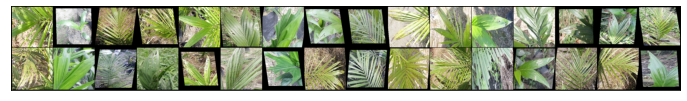

In [6]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

show_batch(dataloaders['train'])

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [8]:
model = models.resnet50(pretrained=True).to(device)
    
for param in model.parameters():
    param.requires_grad = False   
    
model.fc = nn.Sequential(
               nn.Linear(2048, 128),
               nn.ReLU(inplace=True),
               nn.Linear(128, 4)).to(device)

C:\Users\s\AppData\Roaming\Python\Python310\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
C:\Users\s\AppData\Roaming\Python\Python310\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters())

In [10]:
def train_model(model, criterion, optimizer, num_epochs=3):
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                _, preds = torch.max(outputs, 1)
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(image_datasets[phase])
            epoch_acc = running_corrects.double() / len(image_datasets[phase])

            print('{} loss: {:.4f}, acc: {:.4f}'.format(phase,
                                                        epoch_loss,
                                                        epoch_acc))
    return model

In [11]:
model_trained = train_model(model, criterion, optimizer, num_epochs=10)

Epoch 1/10
----------
train loss: 0.8427, acc: 0.6646
validation loss: 0.5254, acc: 0.8192
Epoch 2/10
----------
train loss: 0.5300, acc: 0.8128
validation loss: 0.4058, acc: 0.8524
Epoch 3/10
----------
train loss: 0.3811, acc: 0.8747
validation loss: 0.3180, acc: 0.8838
Epoch 4/10
----------
train loss: 0.3435, acc: 0.8858
validation loss: 0.2849, acc: 0.8985
Epoch 5/10
----------
train loss: 0.2934, acc: 0.8914
validation loss: 0.3904, acc: 0.8653
Epoch 6/10
----------
train loss: 0.2891, acc: 0.9040
validation loss: 0.3825, acc: 0.8579
Epoch 7/10
----------
train loss: 0.2891, acc: 0.8866
validation loss: 0.3027, acc: 0.8985
Epoch 8/10
----------
train loss: 0.2489, acc: 0.9104
validation loss: 0.2288, acc: 0.9244
Epoch 9/10
----------
train loss: 0.2353, acc: 0.9144
validation loss: 0.2160, acc: 0.9262
Epoch 10/10
----------
train loss: 0.2420, acc: 0.9033
validation loss: 0.3185, acc: 0.8911


In [12]:
# !mkdir models
# !mkdir models/pytorch

In [20]:
torch.save(model_trained.state_dict(), 'models/pytorch/weights.h5')

In [21]:
model = models.resnet50(pretrained=False).to(device)
model.fc = nn.Sequential(
               nn.Linear(2048, 128),
               nn.ReLU(inplace=True),
               nn.Linear(128, 4)).to(device)
model.load_state_dict(torch.load('models/pytorch/weights.h5'))

<All keys matched successfully>

In [22]:
validation_img_paths = [
    "test/IMG_5824.JPG",
    "test/IMG_5838.JPG",
    "test/IMG_5961.JPG"
    ]
img_list = [Image.open(input_path + img_path) for img_path in validation_img_paths]

In [23]:
validation_batch = torch.stack([data_transforms['validation'](img).to(device)
                                for img in img_list])

In [24]:
pred_logits_tensor = model(validation_batch)
pred_logits_tensor

tensor([[-0.2191,  2.4312, -2.2592,  1.7761],
        [ 0.2102, -4.8888,  3.5644,  1.2217],
        [-0.8438, -4.8060,  1.9389,  3.4020]], grad_fn=<AddmmBackward0>)

In [25]:
pred_probs = F.softmax(pred_logits_tensor, dim=1).cpu().data.numpy()
pred_probs

array([[4.4167489e-02, 6.2530345e-01, 5.7423054e-03, 3.2478678e-01],
       [3.0884806e-02, 1.8848515e-04, 8.8400638e-01, 8.4920287e-02],
       [1.1495860e-02, 2.1865056e-04, 1.8580440e-01, 8.0248111e-01]],
      dtype=float32)

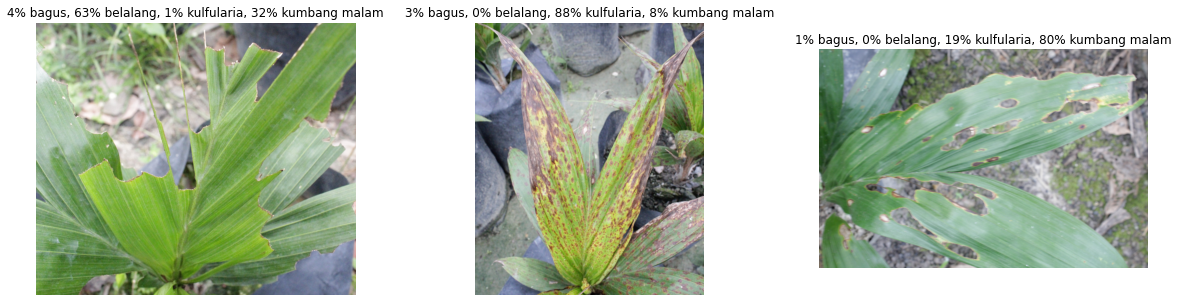

In [26]:
fig, axs = plt.subplots(1, len(img_list), figsize=(20, 5))
for i, img in enumerate(img_list):
    ax = axs[i]
    ax.axis('off')
    ax.set_title("{:.0f}% bagus, {:.0f}% belalang, {:.0f}% kulfularia, {:.0f}% kumbang malam".format(100*pred_probs[i,0],
                                                            100*pred_probs[i,1],100*pred_probs[i,2],100*pred_probs[i,3]))
    ax.imshow(img)